In [1]:
from joblib import dump, load 
import shap 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from fonctions import *
import sage

# Récupération des tables et des modèles construits précédemment

feature_matrix = pd.read_pickle('20230225_table_feature_matrix.csv')
target = pd.read_pickle('20230225_table_target.csv')

feature_dropna = feature_matrix.dropna()
target_dropna = target[feature_dropna.index]

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target, test_size=0.2, random_state=1)


elasticNet = load("optimal_model_en.joblib")
xgb_model = load("optimal_xgb.joblib")
lgbm = load("optimal_model_LGBM.joblib")

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)
train_scaled_df = pd.DataFrame(train_scaled, columns = X_train.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns = X_test.columns)


In [26]:
# On récupère l'explainer du modèle ElasticNet
explainer_en = shap.LinearExplainer(elasticNet, train_scaled, link=shap.links.logit)
shap_values_en = explainer_en.shap_values(test_scaled)
explainer_xgb =  shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
explainer_lgbm =  shap.TreeExplainer(lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


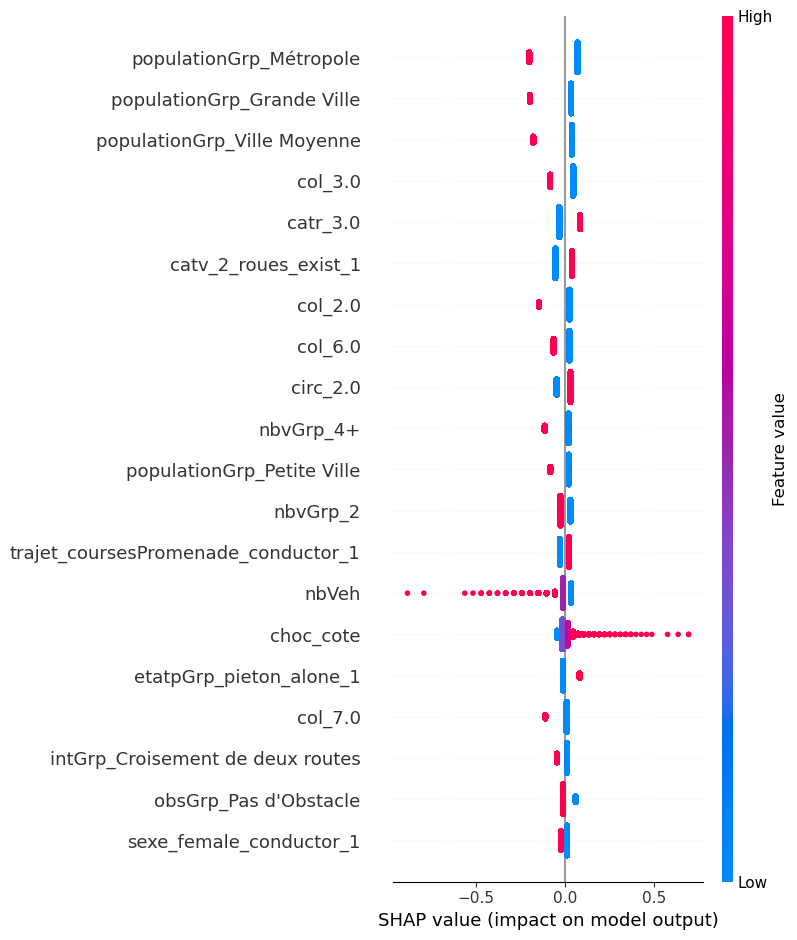

In [27]:
# On regarde les shap_values du modèle EN

shap.summary_plot(shap_values_en, X_test, plot_type='dot')

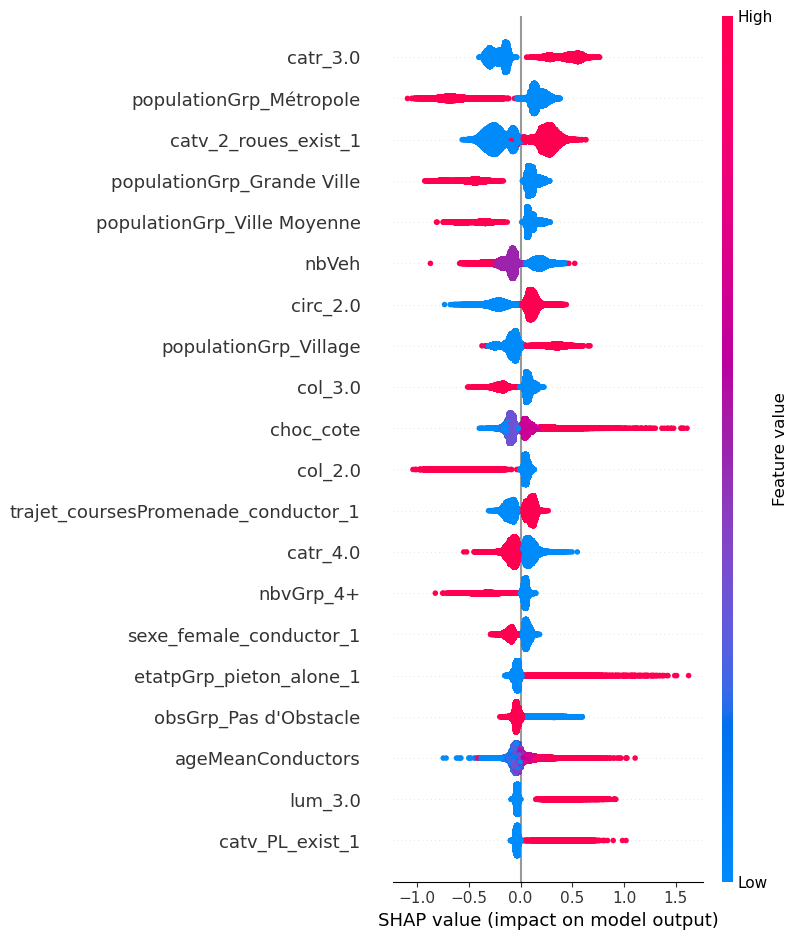

In [28]:
# On regarde les shap_values du modèle XGBoost

shap.summary_plot(shap_values_xgb, X_test, plot_type='dot')


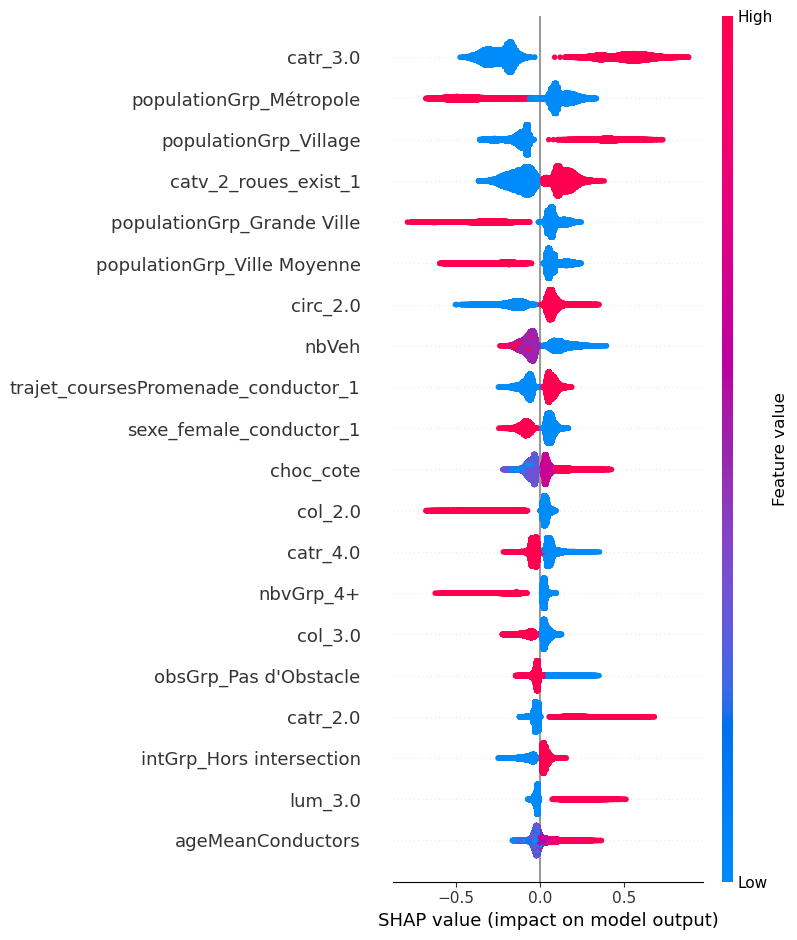

In [31]:
# On regarde les shap_values du modèle LGBM
shap.summary_plot(shap_values_lgbm[1], X_test, plot_type='dot')

In [32]:
# On cherche à comprendre pourquoi et quand le modèle se trompe 
# Pour cela on récupère l'Explainer de shap (pas le treeExplainer), et nous regardons 
# via un waterfall plot quelques individus pour lequel le modèle s'est trompé

y_pred = xgb_model.predict(X_test)

dfModelErrors = X_test[y_test != y_pred].sample(n=20, random_state=1)

dfModelErrors=dfModelErrors.merge(y_test, how ="left", left_index = True, right_index = True)
print(dfModelErrors['gravGrp_2_34'].head(10))


explainer = shap.Explainer(xgb_model, dfModelErrors)
shap_values = explainer(dfModelErrors)

Num_Acc
201500040181    1
201800003499    1
201800017658    0
200500081131    1
200800056717    1
201500036995    1
200500062209    1
200500074339    0
200800025921    1
201100011409    0
Name: gravGrp_2_34, dtype: int32


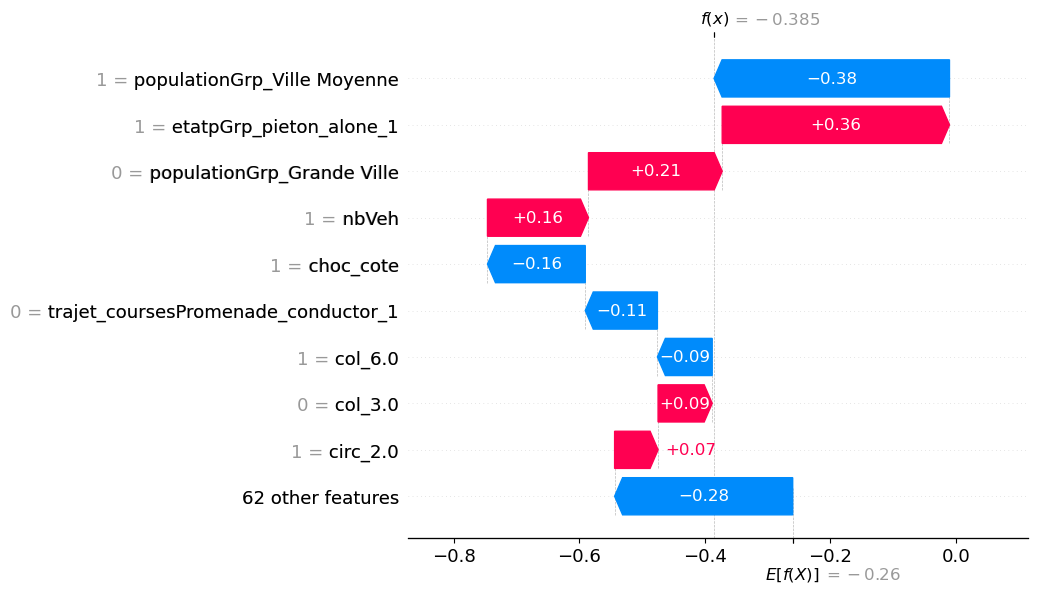

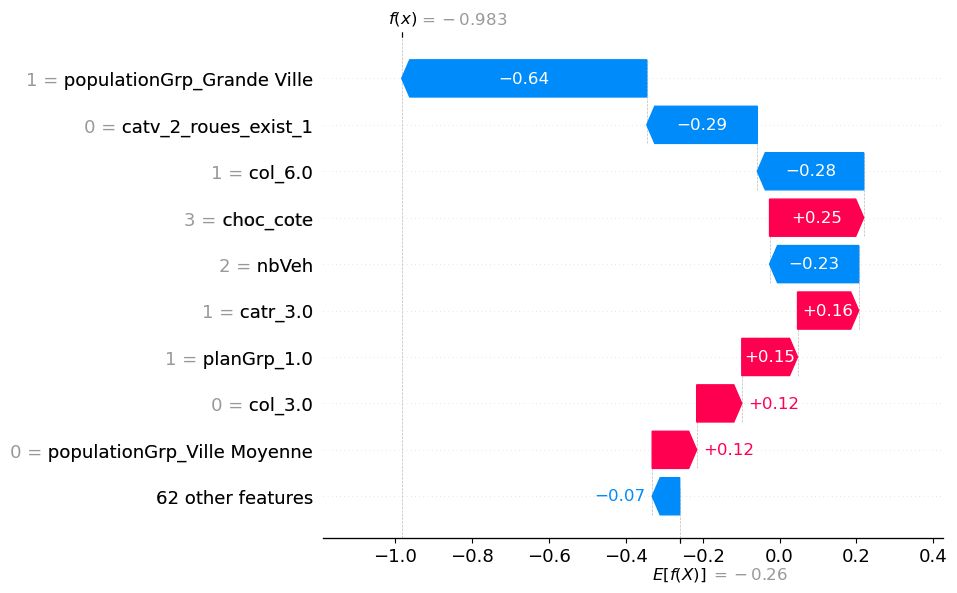

In [33]:
# Les deux premiers accidents ont été graves alors que le modèle ne les a pas prédits comme tel
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])

# Dans les deux cas, la ville de localisation a beaucoup compté dans la classification erronnée, il est donc possible dans certains cas qu'elle ait
# trop d'importance

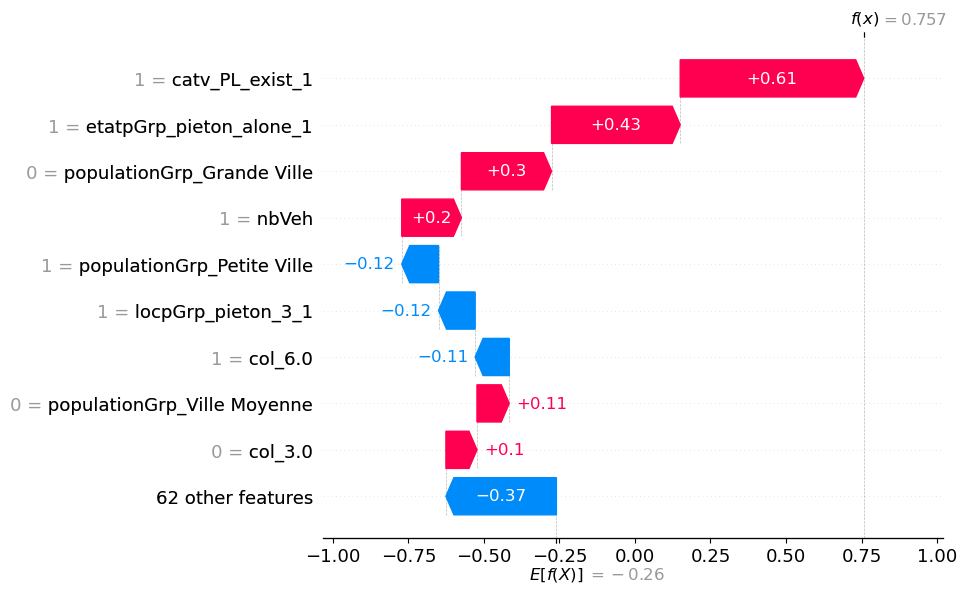

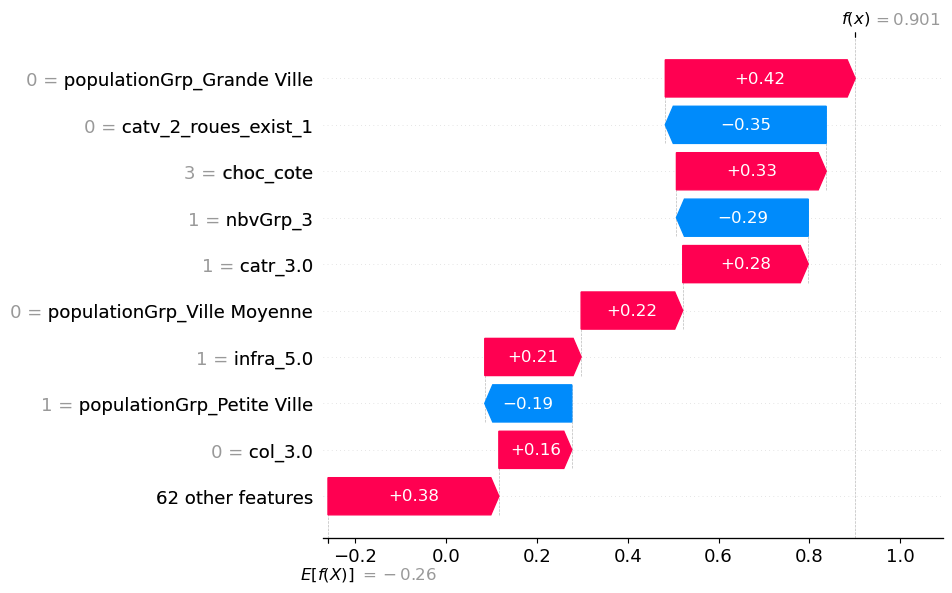

In [34]:
# Les deux premiers accidents présentés ici sont à l'inverse c'est à dire prédits graves sans qu'ils ne l'aient été
shap.plots.waterfall(shap_values[2])
shap.plots.waterfall(shap_values[9])

# Dans le premier cas, la prédiction vient de la présence d'un poids lourd et d'un piéton dans une petite ville 
# Nous pouvons comprendre la prédiction à partir de ces facteurs aggravant, il s'agit ici probablement d'un accident 'miraculeux' sur sa non-gravité

# Pour le 9ème, nous retrouvons une importance démesurée sur la ville de l'accident, le modèle semble se fier beaucoup à ce groupe de variables dans 
# ses erreurs 

In [2]:
# Utilisation de SAGE pour l'importance globale des variables dans les choix du modèle 
# Gourmand en ressources, pas réussi à le faire retourner pour la restitution 

# Get data
x, y = X_test.to_numpy(), y_test.to_numpy()
feature_names = X_test.columns

# Get model
model = xgb_model

# Set up an imputer to handle missing features
imputer = sage.MarginalImputer(model, x[:512])

# Set up an estimator
estimator = sage.PermutationEstimator(imputer, 'cross entropy')

# Calculate SAGE values
sage_values = estimator(x, y)
sage_values.plot(feature_names)

  0%|          | 0/1 [00:00<?, ?it/s]

MemoryError: Unable to allocate 1.00 MiB for an array with shape (262144,) and data type float32